In [1]:
# kd crossover，close < ema 8, ema 8 < ema 18, ema 18 < 38, take profit 4 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1672550900000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    raw_df = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        raw_df = pd.concat([raw_df, out], axis = 0)
    
    raw_df = raw_df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)
    
    raw_df['Close_Time'] = pd.to_datetime(raw_df['Close_Time'], unit = 'ms')
    raw_df['Close_Time'] = raw_df['Close_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Close_Time'] = raw_df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [5]:
raw_df = get_historical(symbol, interval, start_time, end_time, step)
print(raw_df)

               Close_Time     Open    Close     High      Low      Volume
0     2023-01-01 13:44:59  1194.19  1194.10  1194.26  1193.52    541.5214
1     2023-01-01 13:59:59  1194.09  1194.54  1194.67  1194.09    520.3463
2     2023-01-01 14:14:59  1194.55  1194.09  1195.23  1193.97   1376.0106
3     2023-01-01 14:29:59  1194.09  1194.60  1194.92  1194.09   1068.8736
4     2023-01-01 14:44:59  1194.59  1194.37  1194.60  1193.81    642.7820
...                   ...      ...      ...      ...      ...         ...
8250  2023-03-28 13:29:59  1719.49  1716.06  1720.00  1716.06   2736.5849
8251  2023-03-28 13:44:59  1716.06  1717.03  1718.48  1714.27   2859.7516
8252  2023-03-28 13:59:59  1717.03  1724.30  1724.31  1717.02   4996.3460
8253  2023-03-28 14:14:59  1724.31  1730.82  1735.93  1723.62  10206.0536
8254  2023-03-28 14:29:59  1730.82  1731.92  1733.70  1730.82   1503.4880

[8255 rows x 6 columns]


In [6]:
df = raw_df.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slow_k'] < df['slow_d']
    return series.diff()

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

               Close_Time     Open    Close     High      Low      Volume  \
0     2023-01-01 13:44:59  1194.19  1194.10  1194.26  1193.52    541.5214   
1     2023-01-01 13:59:59  1194.09  1194.54  1194.67  1194.09    520.3463   
2     2023-01-01 14:14:59  1194.55  1194.09  1195.23  1193.97   1376.0106   
3     2023-01-01 14:29:59  1194.09  1194.60  1194.92  1194.09   1068.8736   
4     2023-01-01 14:44:59  1194.59  1194.37  1194.60  1193.81    642.7820   
...                   ...      ...      ...      ...      ...         ...   
8250  2023-03-28 13:29:59  1719.49  1716.06  1720.00  1716.06   2736.5849   
8251  2023-03-28 13:44:59  1716.06  1717.03  1718.48  1714.27   2859.7516   
8252  2023-03-28 13:59:59  1717.03  1724.30  1724.31  1717.02   4996.3460   
8253  2023-03-28 14:14:59  1724.31  1730.82  1735.93  1723.62  10206.0536   
8254  2023-03-28 14:29:59  1730.82  1731.92  1733.70  1730.82   1503.4880   

            ema_8       ema_18       ema_38       atr        rsi     slow_k

In [9]:
def conditions(df):

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] <= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] <= df['ema_18']
        # c4
        df['c4'] = df['ema_18'] <= df['ema_38']


    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['open_entry'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_entry'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,rsi,slow_k,slow_d,kd_cross,c1,c2,c3,c4,signal,open_entry
0,2023-01-01 13:44:59,1194.19,1194.10,1194.26,1193.52,541.5214,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2023-01-01 13:59:59,1194.09,1194.54,1194.67,1194.09,520.3463,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2023-01-01 14:14:59,1194.55,1194.09,1195.23,1193.97,1376.0106,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2023-01-01 14:29:59,1194.09,1194.60,1194.92,1194.09,1068.8736,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2023-01-01 14:44:59,1194.59,1194.37,1194.60,1193.81,642.7820,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8250,2023-03-28 13:29:59,1719.49,1716.06,1720.00,1716.06,2736.5849,1715.344780,1714.130885,1715.211726,4.775211,53.191682,63.348837,64.697681,True,True,False,False,True,False,False
8251,2023-03-28 13:44:59,1716.06,1717.03,1718.48,1714.27,2859.7516,1715.719273,1714.436055,1715.304971,4.734839,54.618562,72.372093,72.032565,True,True,False,False,True,False,False
8252,2023-03-28 13:59:59,1717.03,1724.30,1724.31,1717.02,4996.3460,1717.626101,1715.474365,1715.766254,4.917351,63.579571,99.933599,78.551510,False,False,False,False,True,False,False
8253,2023-03-28 14:14:59,1724.31,1730.82,1735.93,1723.62,10206.0536,1720.558079,1717.089695,1716.538241,5.445397,69.412881,80.847076,84.384256,True,True,False,False,False,False,False


In [11]:
entry_df = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']
open_val = entry_df['Open']

for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = open_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] + 3 * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Short'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and entry_df.at[index, 'Close'] > stop_loss:
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit
    elif (entry_df.at[index, 'Low'] <= close_val.shift(1).at[index] - 4 * atr_val.shift(1).at[index]) and in_position == True:
        entry_df.at[index, 'position'] = 'Buy'
        in_position = False
        stop_loss = np.nan

entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Short') |
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


               Close_Time     Open    Close     High      Low      Volume  \
79    2023-01-02 09:29:59  1195.75  1196.09  1196.13  1193.00   3685.1617   
80    2023-01-02 09:44:59  1196.09  1196.03  1196.44  1195.27    953.3041   
81    2023-01-02 09:59:59  1196.03  1195.16  1196.03  1195.09    937.7949   
82    2023-01-02 10:14:59  1195.15  1196.26  1196.41  1194.46   1355.2923   
83    2023-01-02 10:29:59  1196.27  1196.20  1196.42  1195.55    608.6620   
...                   ...      ...      ...      ...      ...         ...   
8224  2023-03-28 06:59:59  1709.56  1709.49  1710.49  1708.46   3013.9641   
8225  2023-03-28 07:14:59  1709.49  1712.42  1713.33  1707.57   3119.4261   
8244  2023-03-28 11:59:59  1710.92  1711.65  1713.10  1710.44   2189.3160   
8245  2023-03-28 12:14:59  1711.65  1712.81  1712.81  1709.53   2670.1858   
8253  2023-03-28 14:14:59  1724.31  1730.82  1735.93  1723.62  10206.0536   

            ema_8       ema_18       ema_38       atr  ...  kd_cross     c1

In [12]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Short') |
              (pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Buy':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'Close'] - 4 * pos.at[i, 'atr']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Short':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Short':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Short', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Buy').sum()
loses = pos['position'].str.count('Stop').sum()
total_pos = pos['position']
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low        ema_8  \
0    2023-01-02 09:44:59  1196.09  1196.03  1196.44  1195.27  1197.635326   
1    2023-01-02 10:14:59  1195.15  1196.26  1196.41  1194.46  1196.901864   
2    2023-01-02 10:29:59  1196.27  1196.20  1196.42  1195.55  1196.745894   
3    2023-01-02 11:59:59  1197.72  1201.94  1203.53  1197.40  1198.072030   
4    2023-01-03 08:44:59  1214.31  1216.41  1216.68  1214.31  1215.712790   
..                   ...      ...      ...      ...      ...          ...   
959  2023-03-28 04:59:59  1704.44  1707.74  1707.97  1703.58  1707.949558   
960  2023-03-28 05:14:59  1707.73  1712.40  1717.21  1706.00  1708.938545   
961  2023-03-28 07:14:59  1709.49  1712.42  1713.33  1707.57  1710.754781   
962  2023-03-28 12:14:59  1711.65  1712.81  1712.81  1709.53  1712.332482   
963  2023-03-28 14:14:59  1724.31  1730.82  1735.93  1723.62  1720.558079   

          ema_18       ema_38       atr kd_cross position  entry_p  \
0    

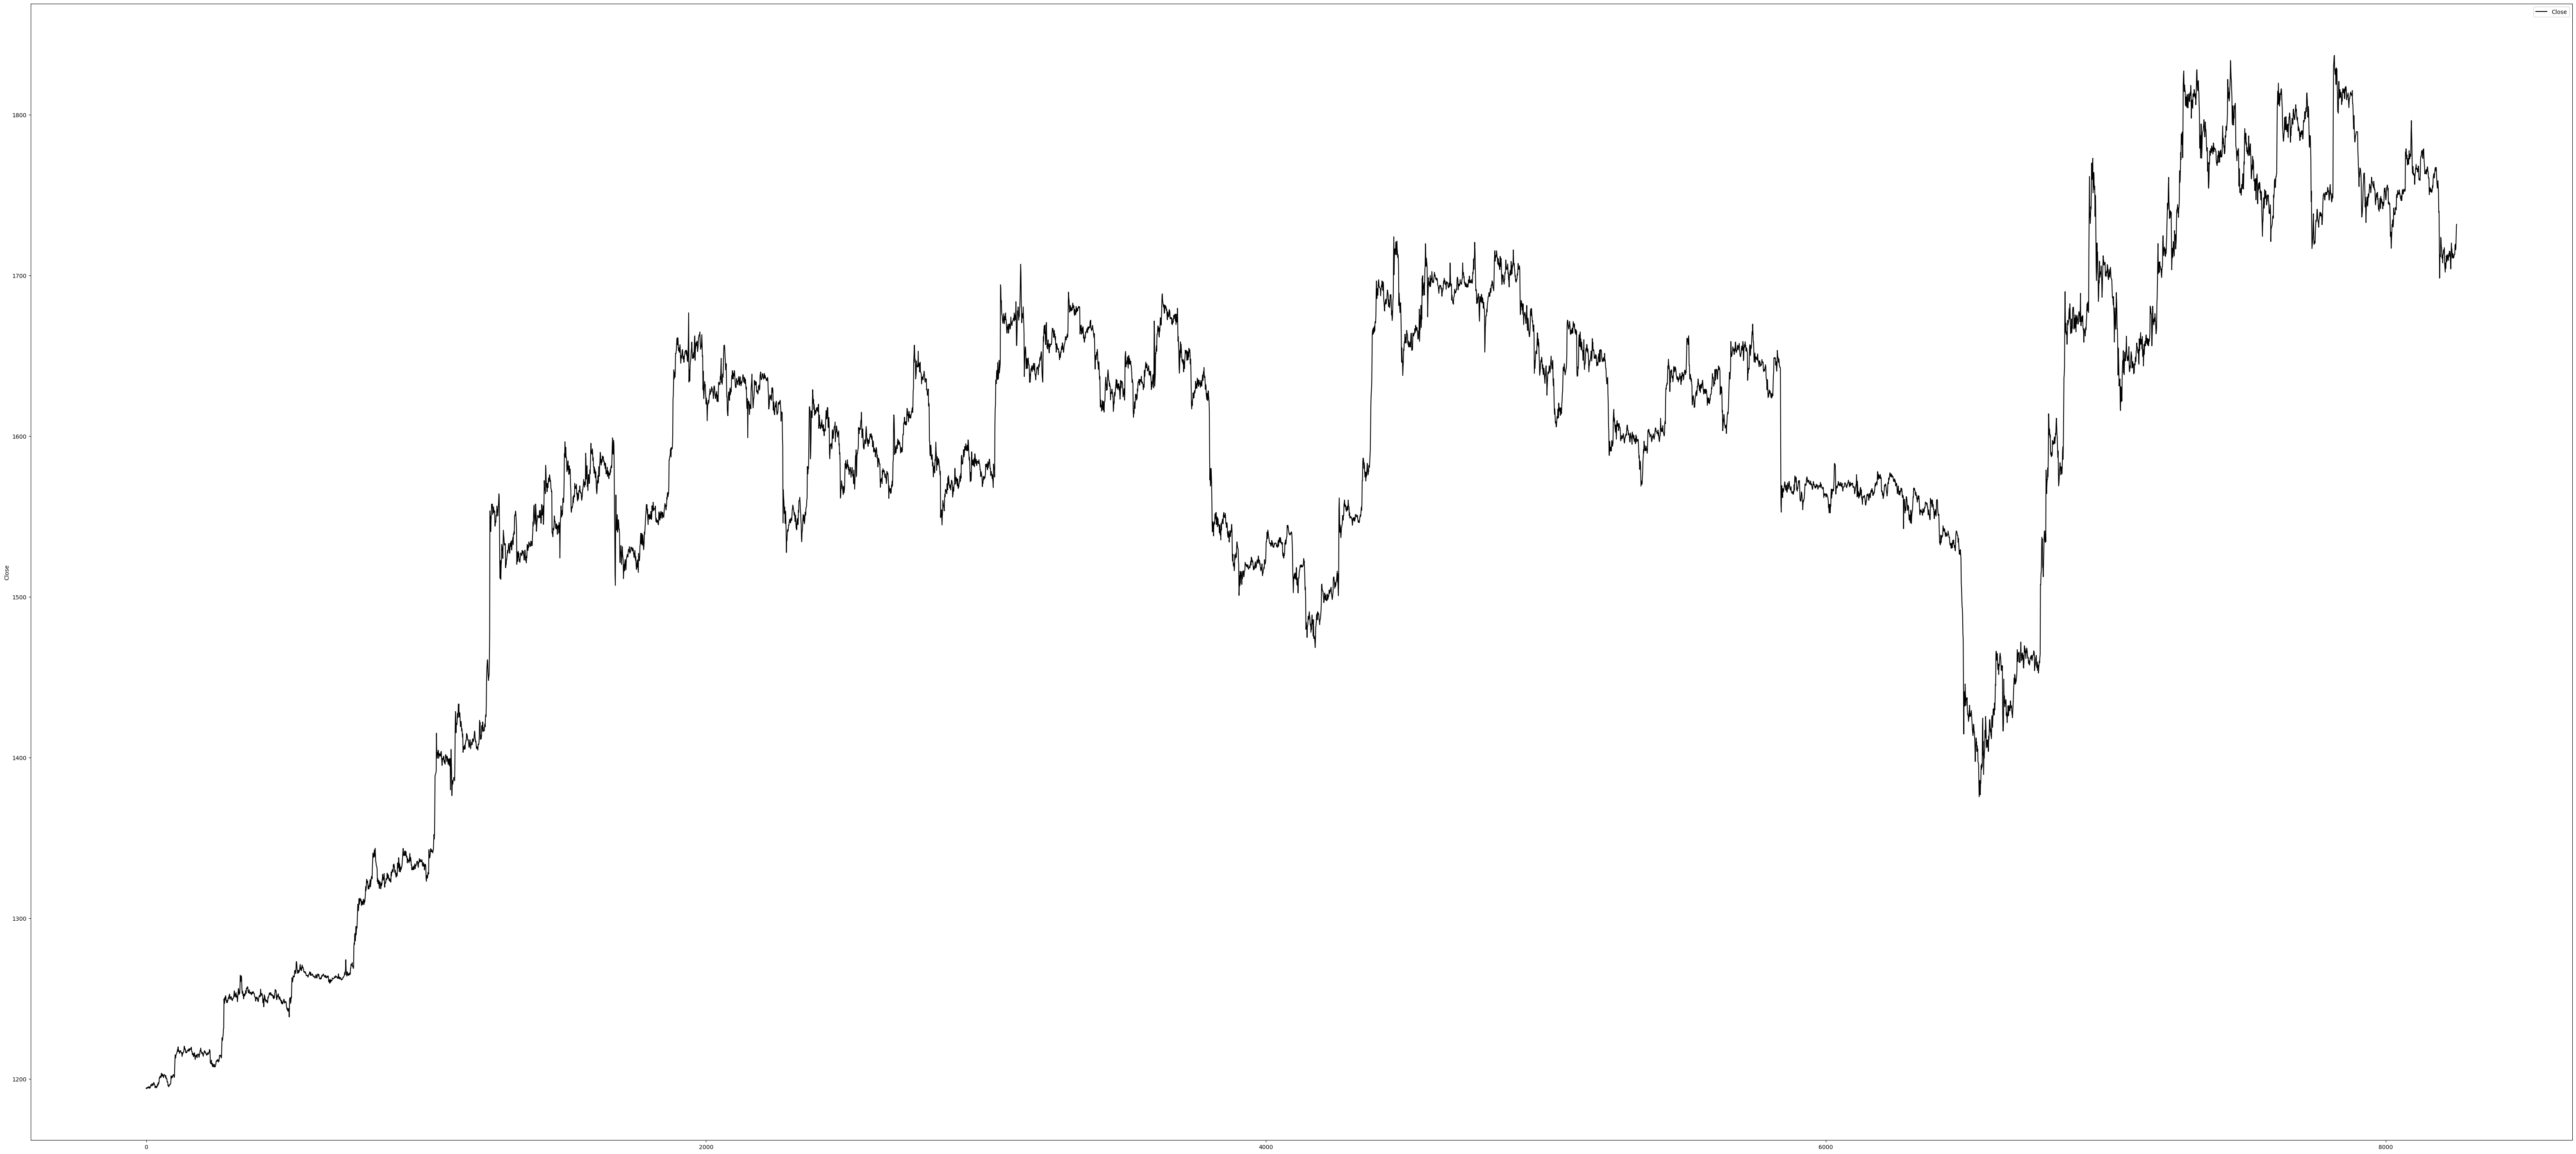

In [13]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')
for i in range(len(plt_df)):
    if plt_df.position[i] == 'Buy':
        plt.plot(i, plt_df.entry_p[i], 'go', label='_', markersize=20)
    elif plt_df.position[i] == 'Stop':
        plt.plot(i, plt_df.entry_p[i], 'ro', label='_', markersize=20)
# plt.plot(plt_df.ema_8, label='ema_8', c='g', lw=0.5)
# plt.plot(plt_df.ema_14, label='ema_14', c='r', lw=0.5)
# plt.plot(plt_df.ema_50, label='ema_50', c='b', lw=0.5)
# plt.plot(plt_df.ema_200, label='ema_200', c='y', lw=4)
plt.legend()
plt.show()